# Gaussian Mixture Modeling of PAS Observations

In this tutorial, we demonstrate how to use **Gaussian Mixture Models (GMM)** to separate the **proton core**, **proton beam**, and **alpha particles** from Solar Orbiter PAS (Proton-Alpha Sensor) observations.

The approach builds upon the methodology presented in [De Marco et al. (2023)](https://doi.org/10.1051/0004-6361/202243719), and extends it by scanning through all reasonable component combinations to identify the optimal classification. This method provides a reproducible and flexible way to identify multiple ion populations in complex solar wind distributions.

> **Author**: Hao Ran ([@hao.ran.24@ucl.ac.uk](mailto:hao.ran.24@ucl.ac.uk))

---

## 💡 Overview of the GMM Setup

- **Number of components**: `n_components = 3`  
  (for proton core, proton beam, and alpha)

- **Feature space**:  
  Each data point is described using a 5-dimensional vector:
  $$
  \mathbf{X} = \left[ V_{\parallel}, V_{\perp1}, V_{\perp2}, |\mathbf{V}|, f \right]
  $$
  where $f$ is the VDF value.

- **Initialization**:
  - The first iteration uses manually specified initial means based on known physical parameters (e.g., Alfvén speed).
  - Subsequent fits use the result from the previous fit as the initialization to improve stability and convergence.

---

## 🧪 Output & Storage

We use an object called "SolarWindParticle" to store the results.
Functions please refer to the "SolarWindPack.py" file.

In [1]:
import os
#s.environ['CDF_LIB'] = '/home/ranhao/codes/cdf39_0-dist/lib'

from spacepy import pycdf
import numpy as np
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
import astropy.constants as const
import astropy
from datetime import datetime, timedelta
import scipy
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema, savgol_filter
import bisect
import pickle

# Functions that I write myself
from Funcs import *
from SolarWindPack import *

In [2]:
# Function to calculate the one-particle noise level.
def OneParticleNoiseLevel(count_cdffile, vdffile):
    # For all the measurement of the day
    vdf = vdffile['vdf'][...] # Extract all the vdf
    vdf_epochs = np.array(vdffile['Epoch'], dtype="datetime64[ms]") # Extract all the epochs, convert to np.array for quicker search.
    counts = count_cdffile['COUNTS'][...] # Extract all the counts
    count_epochs = np.array(count_cdffile['Epoch'], dtype="datetime64[ms]") # Extract all the epochs

    adjusted_vdf_times = vdf_epochs - np.timedelta64(500, 'ms') # Adjust the vdf times to match the counts times
    match_indices = np.searchsorted(count_epochs, adjusted_vdf_times) # Find the indices of the counts that match the vdf times
    counts = counts[match_indices] # Get the counts that match the vdf times

    noise_level = np.divide(vdf, counts, out=np.zeros_like(vdf, dtype=float), where=counts != 0) # Calculate the noise level
    noise_level[np.isnan(noise_level)] = 0 # Drop the NaN values and replace them with 0.
    one_particle_noise_level = np.nanpercentile(noise_level, 99.9, axis=0)

    return one_particle_noise_level

In [3]:
# specify your data files.
yymmdd = '20220302'
data_list = os.listdir(f'data/SO/{yymmdd}')

vdf_fname = next(file for file in data_list if 'pas-vdf' in file and not file.startswith('._'))
grnd_fname = next(file for file in data_list if 'pas-grnd-mom' in file and not file.startswith('._'))
mag_fname = next(file for file in data_list if 'mag-srf-normal' in file and not file.startswith('._'))
#eflux_fname = next(file for file in data_list if 'pas-eflux' in file and not file.startswith('._'))
count_fname = next(file for file in data_list if 'pas-3d' in file and not file.startswith('._'))

vdf_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{vdf_fname}')
grnd_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{grnd_fname}')
mag_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{mag_fname}')
#eflux_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{eflux_fname}')
count_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{count_fname}')

In [4]:
# generate the one-particle noise level
#one_particle_noise_level = OneParticleNoiseLevel(count_cdffile, vdf_cdffile)
#np.savez(f'result/SO/{yymmdd}/one_particle_noise_level.npz', noise_level=one_particle_noise_level)

# If you have already generated the one-particle noise level, you can load it directly.
loaded_data = np.load(f'result/SO/{yymmdd}/one_particle_noise_level.npz')
one_particle_noise_level = loaded_data['noise_level']

Specify the timeslice where you want you GMM to start.

In [5]:
# Please
timeslice = datetime(2022, 3, 2, 0, 0, 10)
yymmdd = timeslice.strftime("%Y%m%d")
hhmmss = timeslice.strftime("%H%M%S")
epoch_vdf = vdf_cdffile['Epoch'][...]
epoch_mag = mag_cdffile['EPOCH'][...]

tsliceindex_vdf = bisect.bisect_left(epoch_vdf, timeslice)
measured_time = epoch_vdf[tsliceindex_vdf]
print('Time for VDF: ', measured_time)
print("Time index for VDF: ", tsliceindex_vdf)

# Average the B field within the following timerange to get the B field.
tslice_vdf_start = epoch_vdf[tsliceindex_vdf] - timedelta(seconds=0.5)
tslice_vdf_end = epoch_vdf[tsliceindex_vdf] + timedelta(seconds=0.5)
tsliceindex_mag_start = bisect.bisect_left(epoch_mag, tslice_vdf_start)
tsliceindex_mag_end = bisect.bisect_left(epoch_mag, tslice_vdf_end)
print('Time for MAG: ', epoch_mag[tsliceindex_mag_start], " to ", epoch_mag[tsliceindex_mag_end])
print("Time index for MAG: ", tsliceindex_mag_start, " to ", tsliceindex_mag_end)

# Read data from SO product.
V_bulk_SRF = grnd_cdffile['V_SRF'][tsliceindex_vdf]
vdf = vdf_cdffile['vdf'][tsliceindex_vdf]

qp = 1.60217662e-19 # C
mp = 1.6726219e-27 # kg

vel = np.sqrt(2 * vdf_cdffile['Energy'][...] * qp / mp) / 1e3 * (u.km / u.s) # in km/s
theta = vdf_cdffile['Elevation'][...] * u.deg # in deg
phi = vdf_cdffile['Azimuth'][...] * u.deg # in deg

magF_SRF = mag_cdffile['B_SRF'][tsliceindex_mag_start:tsliceindex_mag_end].mean(axis=0)
print('Magnetic feild in SRF: ', magF_SRF)

# Calculate the local Alfven speed to set initial means.
B_magnitude = np.sqrt(np.sum(magF_SRF**2)) * 1e-9  #T
density = grnd_cdffile['N'][tsliceindex_vdf] * 1e6 # m^-3
mu0 = 4 * np.pi * 1e-7 # N/A^2
mp = 1.67*1e-27 # kg

VA = B_magnitude / np.sqrt(mu0 * density * mp) / 1000.0 #  km/s
print('Local Alfven speed: ', VA)

# Consider the one-particel noise level.
print(vdf.shape)
print(one_particle_noise_level.shape)

# Any anode with measurement below the noise level is considered as noise, and removed.
vdf_corrected = vdf.copy()
vdf_corrected[vdf_corrected <= one_particle_noise_level] = 0

print("Before removing one-particel noise: ", np.count_nonzero(vdf))
print("After removing one-particel noise: ", np.count_nonzero(vdf_corrected))

# Let's first get the f and (vx, vy, vz) grid points.
vx = np.zeros((11, 9, 96))
vy = np.zeros((11, 9, 96))
vz = np.zeros((11, 9, 96))

# Calculate in SRF coordinate, proton bulk frame.
for i in range(11):
    for j in range(9):
        vx[i, j, :] = - vel * np.cos(theta[j]) * np.cos(phi[i]) - V_bulk_SRF[0] * u.km / u.s
        vy[i, j, :] = vel * np.cos(theta[j]) * np.sin(phi[i]) - V_bulk_SRF[1] * u.km / u.s
        vz[i, j, :] = - vel * np.sin(theta[j]) - V_bulk_SRF[2] * u.km / u.s

(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz) = fieldAlignedCoordinates(magF_SRF[0], magF_SRF[1], magF_SRF[2])
(V_para, V_perp1, V_perp2) = rotateVectorIntoFieldAligned(vx, vy, vz, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
(V_para_bulk, V_perp1_bulk, V_perp2_bulk) = rotateVectorIntoFieldAligned(V_bulk_SRF[0], V_bulk_SRF[1], V_bulk_SRF[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
V_perp = np.sqrt(V_perp1**2 + V_perp2**2)
print('V_bulk_field_aligned: ', V_para_bulk, V_perp1_bulk, V_perp2_bulk)

# Generate the path for saving the result.
hhmmss = tslice_vdf_start.strftime("%H%M%S")
result_path = f'result/SO/{yymmdd}/Particles/Ions/{hhmmss}'
if not os.path.exists(result_path):
    os.makedirs(result_path)

Time for VDF:  2022-03-02 00:00:17.541148
Time index for VDF:  1
Time for MAG:  2022-03-02 00:00:17.099002  to  2022-03-02 00:00:18.098997
Time index for MAG:  136  to  144
Magnetic feild in SRF:  [ -7.484046  -12.459379    0.8517713]
Local Alfven speed:  65.22504188338681
(11, 9, 96)
(11, 9, 96)
Before removing one-particel noise:  750
After removing one-particel noise:  463
V_bulk_field_aligned:  297.6301999406901 69.4480925798538 -517.2868584462652


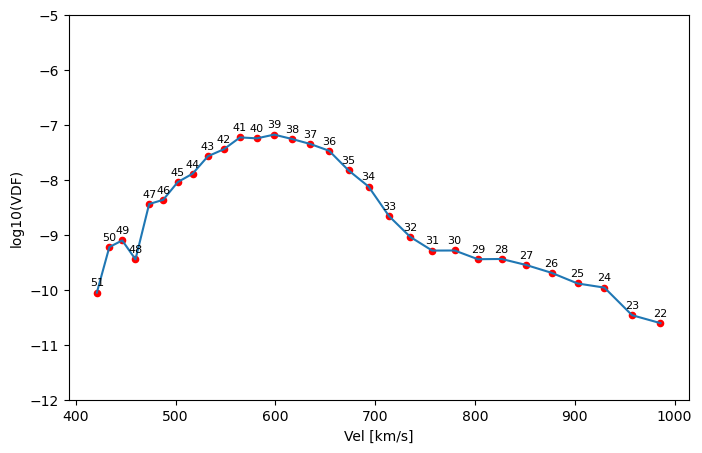

In [6]:
def log10_vdf(vdf):
    vdf = np.array(vdf)  # Ensure vdf is a NumPy array
    mask = vdf > 0  # Create a mask for positive values
    result = np.zeros_like(vdf)  # Initialize an array of zeros
    result[mask] = np.log10(vdf[mask])  # Compute log10 only for positive values
    return result

y = log10_vdf(np.sum(vdf_corrected, axis=(0, 1)))
mask = y != 0
x = vel[mask]
y = y[mask]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y, label='Corrected VDF')
ax.scatter(x, y, s=20, color='red')
ax.set_ylim(-12, -5)
for idx, (xi, yi) in enumerate(zip(x.value, y)):
    ax.annotate(str(np.where(mask)[0][idx]), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
ax.set_xlabel('Vel [km/s]')
ax.set_ylabel('log10(VDF)')
plt.savefig(result_path + '/Corrected_VDF_1D.png')

In [7]:
# Correct again. Remove the points who have no neighboring points.
def remove_noise(vdf_corrected):
    """
    Set to zero any point in vdf_corrected (shape: 11, 9, 96)
    that does not have at least one neighbor with a positive value.
    
    Parameters:
        vdf_corrected (ndarray): 3D array of shape (11, 9, 96)
    
    Returns:
        ndarray: Cleaned array with noise points set to zero
    """
    # Initialize a mask of False
    neighbor_mask = np.zeros_like(vdf_corrected, dtype=bool)

    # Axis 0 neighbors
    neighbor_mask[:-1, :, :] |= vdf_corrected[1:, :, :] > 0
    neighbor_mask[1:, :, :] |= vdf_corrected[:-1, :, :] > 0

    # Axis 1 neighbors
    neighbor_mask[:, :-1, :] |= vdf_corrected[:, 1:, :] > 0
    neighbor_mask[:, 1:, :] |= vdf_corrected[:, :-1, :] > 0

    # Axis 2 neighbors
    neighbor_mask[:, :, :-1] |= vdf_corrected[:, :, 1:] > 0
    neighbor_mask[:, :, 1:] |= vdf_corrected[:, :, :-1] > 0

    # Zero out points with no positive neighbor
    cleaned_vdf = vdf_corrected.copy()
    cleaned_vdf[~neighbor_mask] = 0

    return cleaned_vdf

vdf_2ndcorrected = remove_noise(vdf_corrected)

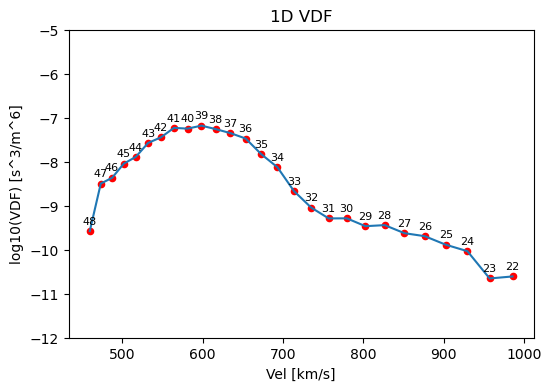

In [8]:
y = log10_vdf(np.sum(vdf_2ndcorrected, axis=(0, 1)))
mask = y != 0
x = vel[mask]
y = y[mask]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, label='Corrected VDF')
ax.scatter(x, y, s=20, color='red')
ax.set_ylim(-12, -5)
for idx, (xi, yi) in enumerate(zip(x.value, y)):
    ax.annotate(str(np.where(mask)[0][idx]), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
ax.set_xlabel('Vel [km/s]')
ax.set_ylabel('log10(VDF) [s^3/m^6]')
ax.set_title('1D VDF')
plt.savefig(result_path + '/Corrected_VDF_Cleaned.png')

In [9]:
# Please maually specify the separation velocity index between alpha and proton.
dividing_idx = 31

In [10]:
# The dividing index between protons and alphas (Manually specified.).
f_proton = np.zeros_like(vdf_2ndcorrected)
f_proton[:, :, dividing_idx:] = vdf_2ndcorrected[:, :, dividing_idx:]
f_alpha = np.zeros_like(vdf_corrected)
f_alpha[:, :, :dividing_idx] = vdf_2ndcorrected[:, :, :dividing_idx]

# Mind here, grid is in the order of theta, phi, vel., and units are in deg, deg, m/s.
Protons_initial = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_initial.set_vdf(f_proton)

Alphas_initial = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3 / np.sqrt(2)], coord_type='Spherical')
Alphas_initial.set_vdf(f_alpha * 4)

# Velocities
Vproton = cal_bulk_velocity_Spherical(Protons_initial)
Valpha = cal_bulk_velocity_Spherical(Alphas_initial)
Vproton_Baligned = rotateVectorIntoFieldAligned(Vproton[0], Vproton[1], Vproton[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
Valpha_Baligned = rotateVectorIntoFieldAligned(Valpha[0], Valpha[1], Valpha[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VprotonPara, VprotonPerp = Vproton_Baligned[0], np.sqrt(Vproton_Baligned[1]**2 + Vproton_Baligned[2]**2)
ValphaPara, ValphaPerp = Valpha_Baligned[0], np.sqrt(Valpha_Baligned[1]**2 + Valpha_Baligned[2]**2)

print(Protons_initial)
print(Alphas_initial)
print("Np: ", cal_density_Spherical(Protons_initial) / 1e6)
print("Moment density: ", density / 1e6)
print("Na: ", cal_density_Spherical(Alphas_initial) / 1e6)
print("Na / Np: ", cal_density_Spherical(Alphas_initial) / cal_density_Spherical(Protons_initial))
print("Vp: ", cal_bulk_velocity_Spherical(Protons_initial) / 1e3)
print("Va: ", cal_bulk_velocity_Spherical(Alphas_initial) / 1e3)
print("Vp_Baligned: ", VprotonPara / 1e3, VprotonPerp / 1e3)
print("Va_Baligned: ", ValphaPara / 1e3, ValphaPerp / 1e3)
print("VA: ", VA)

Species = proton, Time = 2022-03-02 00:00:17.541148, Magnetic Field = [ -7.484046  -12.459379    0.8517713], VDF = single VDF set, Coordinate Grids Set in Spherical
Species = alpha, Time = 2022-03-02 00:00:17.541148, Magnetic Field = [ -7.484046  -12.459379    0.8517713], VDF = single VDF set, Coordinate Grids Set in Spherical
Np:  25.389768
Moment density:  23.742401123046875
Na:  0.45037275
Na / Np:  0.01773835625437775
Vp:  [-599.15696921   11.90678297    5.7010459 ]
Va:  [-589.74276624   43.97894556    6.63828269]
Vp_Baligned:  298.13449826315605 519.8838025050813
Va_Baligned:  265.9036941078532 528.2707357425637
VA:  65.22504188338681


In [11]:
diff_alpha_core = (np.array(Valpha_Baligned) - np.array(Vproton_Baligned)) / 1e3

# Initial means for GMM.
initial_means = np.array([
    [0, 0, 0, 0, Protons_initial.get_vdf().max()], 
    [VA, 0, 0, VA, Protons_initial.get_vdf().max() / 10.0],
    np.append(np.append(diff_alpha_core, np.linalg.norm(diff_alpha_core)), Alphas_initial.get_vdf().max())
])

In [12]:
def cal_GMM_first(V_para, V_perp1, V_perp2, vdf_corrected, co_type, initial_means, n_component):
    # Function for GMM.
    non_zero_idx = np.where(vdf_corrected > 0)
    non_zero_vdf = vdf_corrected[non_zero_idx]
    non_zero_vpara = V_para[non_zero_idx]
    non_zero_vperp1 = V_perp1[non_zero_idx]
    non_zero_vperp2 = V_perp2[non_zero_idx]
    non_zero_magni = np.sqrt(non_zero_vpara**2 + non_zero_vperp1**2 + non_zero_vperp2**2)
    
    X = np.column_stack([non_zero_vpara, non_zero_vperp1, non_zero_vperp2, non_zero_magni, non_zero_vdf])

    # Use KMeans to determine initial weights
    kmeans = KMeans(n_clusters=n_component, random_state=0).fit(X)
    labels = kmeans.labels_
    # Compute the initial weights as the fraction of samples in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    initial_weights = counts / len(labels)

    gmm_kwargs = {
        "n_components": n_component,
        "random_state": 42,
        "covariance_type": co_type,
        "means_init": initial_means,
        "weights_init": initial_weights,
    }

    gmm = GaussianMixture(**gmm_kwargs).fit(X)
    probas = gmm.predict_proba(X)

    f_all = [np.zeros_like(vdf_corrected) for _ in range(n_component)]

    for i in range(n_component):
        f_all[i][non_zero_idx] = probas[:, i] * vdf_corrected[non_zero_idx]

    # Determine alpha.
    # Scan from large speed to low speed, whichever starts with a higher speed is alpha.
    def find_first_nonzero_index(f_1d):
        return np.argmax(f_1d > 0)  # gives first non-zero index

    # Step 1: Reduce to 1D
    f0_1d = np.sum(f_all[0], axis=(0, 1))
    f1_1d = np.sum(f_all[1], axis=(0, 1))
    f2_1d = np.sum(f_all[2], axis=(0, 1))

    # Step 2: Get first non-zero indices
    a = find_first_nonzero_index(f0_1d)
    b = find_first_nonzero_index(f1_1d)
    c = find_first_nonzero_index(f2_1d)

    # Step 3: Find smallest index shared across all
    idx = min(a, b, c)

    # Step 4: Compare values at this index
    values_at_idx = [f0_1d[idx], f1_1d[idx], f2_1d[idx]]
    alpha_index = int(np.argmax(values_at_idx))
    
    # Among the remaining two, determine core and beam based on peak value
    remaining_indices = [i for i in range(n_component) if i != alpha_index]
    peak_values = [np.max(f_all[i]) for i in remaining_indices]
    if peak_values[0] >= peak_values[1]:
        core_index = remaining_indices[0]
        beam_index = remaining_indices[1]
    else:
        core_index = remaining_indices[1]
        beam_index = remaining_indices[0]

    # Reorder f_all accordingly: [core, beam, alpha]
    sort_indices = [alpha_index, beam_index, core_index]

    # Sort covariance using the same indices
    f_all_sorted = [f_all[i] for i in sort_indices]
    covariance_sorted = [gmm.covariances_[i] for i in sort_indices]
    means_sorted = [gmm.means_[i] for i in sort_indices]
    weights_sorted = [gmm.weights_[i] for i in sort_indices]
    
    
    # Set small values to 0 in f_all.
    for f in f_all_sorted:
        f[f < 1e-14] = 0

    # Get the BIC scores.
    k_dict = {
        'full': 62,     # 3 * 5 + 3 * (5 * (5 = 1)) / 2 + 2 
        'spherical': 20,    # 3 * 5 + 3 + 2 
        'diag': 32,    # 3 * 5 + 3 * 5 + 2
        'tied': 32,    # 3 * 5 + 3 + 2
    }

    n = len(non_zero_idx[0])
    AIC_score = - 2 * gmm.score(X) + 2 * k_dict[co_type]
    BIC_score = k_dict[co_type] * np.log(n) - 2 * gmm.score(X)
    scores = [AIC_score, BIC_score]

    return f_all_sorted, [means_sorted, covariance_sorted, weights_sorted], probas


In [13]:
n_component = 3

# We should try all covariance types.
f_full, dist_paras_full, probas_full = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'full', initial_means, n_component)
f_alpha_full, f_beam_full, f_core_full = f_full

f_diag, dist_paras_diag, probas_diag = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'diag', initial_means, n_component)
f_alpha_diag, f_beam_diag, f_core_diag = f_diag

f_spherical, dist_paras_spherical, probas_spherical = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'spherical', initial_means, n_component)
f_alpha_spherical, f_beam_spherical, f_core_spherical = f_spherical

f_tied, dist_paras_tied, probas_tied = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'tied', initial_means, n_component)
f_alpha_tied, f_beam_tied, f_core_tied = f_tied

In [14]:
# Functions for plotting.
def log10_1D_dist(vel, vdf):
    y = log10_vdf(np.sum(vdf, axis=(0, 1)))
    mask = y != 0
    x = vel[mask]
    y = y[mask]
    return x, y

# A function for plotting.
def plot_one(ax1, ax2, vdf_total, f_core, f_beam, f_alpha, co_type):
    x, y = log10_1D_dist(vel, vdf_total)
    ax1.plot(x, y, label='Total', color='black')
    ax1.scatter(x, y, s=20, color='black', marker='s')
    x, y = log10_1D_dist(vel, f_core)
    ax1.plot(x, y, label='core', color='red')
    ax1.scatter(x, y, s=10, color='red')
    x, y = log10_1D_dist(vel, f_beam)
    ax1.plot(x, y, label='Beam', color='blue')
    ax1.scatter(x, y, s=10, color='blue')
    x, y = log10_1D_dist(vel, f_alpha)
    ax1.plot(x, y, label='Alpha', color='green')
    ax1.scatter(x, y, s=10, color='green')
    ax1.set_ylim(-12, -5)
    ax1.set_title(co_type)
    ax1.set_xlabel('Vel [km/s]')
    ax1.set_ylabel('log10(VDF)')
    ax1.legend()

    x, y = log10_1D_dist(vel, vdf_total)
    ax2.plot(x, y, label='Total', color='black')
    ax2.scatter(x, y, s=20, color='black', marker='s')
    x, y = log10_1D_dist(vel, f_core + f_beam)
    ax2.plot(x, y, label='Proton', color='red')
    ax2.scatter(x, y, s=10, color='red')
    x, y = log10_1D_dist(vel, f_alpha)
    ax2.plot(x, y, label='Alpha', color='green')
    ax2.scatter(x, y, s=10, color='green')
    ax2.set_ylim(-12, -5)
    ax2.set_xlabel('Vel [km/s]')
    ax2.set_ylabel('log10(VDF)')
    ax2.legend()

    return 0

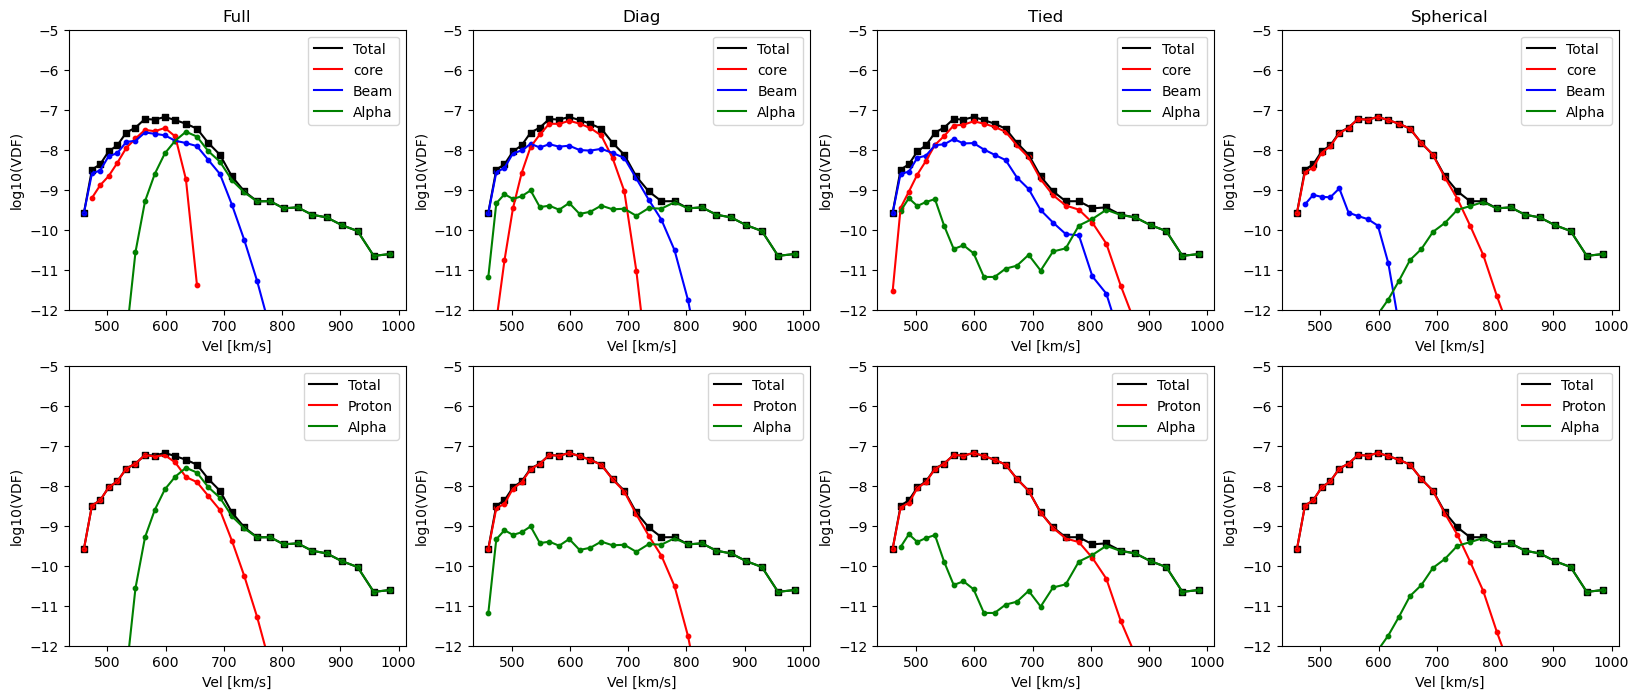

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
# Full 
plot_one(ax[0, 0], ax[1, 0], vdf_2ndcorrected, f_core_full, f_beam_full, f_alpha_full, 'Full')
#plot_one(ax[0, 0], ax[1, 0], vdf_2ndcorrected, f_proton_full, f_alpha_full, 'Full')

# diag
plot_one(ax[0, 1], ax[1, 1], vdf_2ndcorrected, f_core_diag, f_beam_diag, f_alpha_diag, 'Diag')

#plot_one(ax[0, 1], ax[1, 1], vdf_2ndcorrected, f_proton_diag, f_alpha_diag, 'Diag')

# tied
plot_one(ax[0, 2], ax[1, 2], vdf_2ndcorrected, f_core_tied, f_beam_tied, f_alpha_tied, 'Tied')
# plot_one(ax[0, 2], ax[1, 2], vdf_2ndcorrected, f_proton_tied, f_alpha_tied, 'Tied')

# spherical
plot_one(ax[0, 3], ax[1, 3], vdf_2ndcorrected, f_core_spherical, f_beam_spherical, f_alpha_spherical, 'Spherical')
#plot_one(ax[0, 3], ax[1, 3], vdf_2ndcorrected, f_proton_spherical, f_alpha_spherical, 'Spherical')

plt.savefig(result_path + '/GMM_all.png')

In [16]:
# Full usually fails. Let's go with "diag", "tied", and "spherical".
Protons_diag = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_diag.set_vdf(f_core_diag, 'core')
Protons_diag.set_vdf(f_beam_diag, 'beam')

Alphas_diag = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3 / np.sqrt(2)], coord_type='Spherical')
Alphas_diag.set_vdf(f_alpha_diag * 4)


Protons_spherical = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_spherical.set_vdf(f_core_spherical, 'core')
Protons_spherical.set_vdf(f_beam_spherical, 'beam')

Alphas_spherical = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3 / np.sqrt(2)], coord_type='Spherical')
Alphas_spherical.set_vdf(f_alpha_spherical * 4)


Protons_tied = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_tied.set_vdf(f_core_tied, 'core')
Protons_tied.set_vdf(f_beam_tied, 'beam')

Alphas_tied = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3 / np.sqrt(2)], coord_type='Spherical')
Alphas_tied.set_vdf(f_alpha_tied * 4)

In [17]:
# Print the moments to see what the results look like.
Vpcore_diag = cal_bulk_velocity_Spherical(Protons_diag, 'core') / 1e3
Vpbeam_diag = cal_bulk_velocity_Spherical(Protons_diag, 'beam') / 1e3
Valpha_diag = cal_bulk_velocity_Spherical(Alphas_diag) / 1e3
Vpcore_spherical = cal_bulk_velocity_Spherical(Protons_spherical, 'core') / 1e3
Vpbeam_spherical = cal_bulk_velocity_Spherical(Protons_spherical, 'beam') / 1e3
Valpha_spherical = cal_bulk_velocity_Spherical(Alphas_spherical) / 1e3
Vpcore_tied = cal_bulk_velocity_Spherical(Protons_tied, 'core') / 1e3
Vpbeam_tied = cal_bulk_velocity_Spherical(Protons_tied, 'beam') / 1e3
Valpha_tied = cal_bulk_velocity_Spherical(Alphas_tied) / 1e3

VpcoreDiagBaligned = rotateVectorIntoFieldAligned(Vpcore_diag[0], Vpcore_diag[1], Vpcore_diag[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpcoreDiagPara, VpcoreDiagPerp = VpcoreDiagBaligned[0], np.sqrt(VpcoreDiagBaligned[1]**2 + VpcoreDiagBaligned[2]**2)
VpbeamDiagBaligned = rotateVectorIntoFieldAligned(Vpbeam_diag[0], Vpbeam_diag[1], Vpbeam_diag[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpbeamDiagPara, VpbeamDiagPerp = VpbeamDiagBaligned[0], np.sqrt(VpbeamDiagBaligned[1]**2 + VpbeamDiagBaligned[2]**2)
ValphaDiagBaligned = rotateVectorIntoFieldAligned(Valpha_diag[0], Valpha_diag[1], Valpha_diag[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
ValphaDiagPara, ValphaDiagPerp = ValphaDiagBaligned[0], np.sqrt(ValphaDiagBaligned[1]**2 + ValphaDiagBaligned[2]**2)

VpcoreSphericalBaligned = rotateVectorIntoFieldAligned(Vpcore_spherical[0], Vpcore_spherical[1], Vpcore_spherical[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpcoreSphericalPara, VpcoreSphericalPerp = VpcoreSphericalBaligned[0], np.sqrt(VpcoreSphericalBaligned[1]**2 + VpcoreSphericalBaligned[2]**2)
VpbeamSphericalBaligned = rotateVectorIntoFieldAligned(Vpbeam_spherical[0], Vpbeam_spherical[1], Vpbeam_spherical[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpbeamSphericalPara, VpbeamSphericalPerp = VpbeamSphericalBaligned[0], np.sqrt(VpbeamSphericalBaligned[1]**2 + VpbeamSphericalBaligned[2]**2)
ValphaSphericalBaligned = rotateVectorIntoFieldAligned(Valpha_spherical[0], Valpha_spherical[1], Valpha_spherical[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
ValphaSphericalPara, ValphaSphericalPerp = ValphaSphericalBaligned[0], np.sqrt(ValphaSphericalBaligned[1]**2 + ValphaSphericalBaligned[2]**2)

VpcoreTiedBaligned = rotateVectorIntoFieldAligned(Vpcore_tied[0], Vpcore_tied[1], Vpcore_tied[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpcoreTiedPara, VpcoreTiedPerp = VpcoreTiedBaligned[0], np.sqrt(VpcoreTiedBaligned[1]**2 + VpcoreTiedBaligned[2]**2)
VpbeamTiedBaligned = rotateVectorIntoFieldAligned(Vpbeam_tied[0], Vpbeam_tied[1], Vpbeam_tied[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpbeamTiedPara, VpbeamTiedPerp = VpbeamTiedBaligned[0], np.sqrt(VpbeamTiedBaligned[1]**2 + VpbeamTiedBaligned[2]**2)
ValphaTiedBaligned = rotateVectorIntoFieldAligned(Valpha_tied[0], Valpha_tied[1], Valpha_tied[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
ValphaTiedPara, ValphaTiedPerp = ValphaTiedBaligned[0], np.sqrt(ValphaTiedBaligned[1]**2 + ValphaTiedBaligned[2]**2)

# Calculate the angle between drift speeds with respect to the magnetic field.
Theta_PCore_Beam_Diag = np.arctan((VpbeamDiagPerp - VpcoreDiagPerp) / (VpbeamDiagPara - VpcoreDiagPara)) * 180 / np.pi
Theta_PCore_Alpha_Diag = np.arctan((ValphaDiagPerp - VpcoreDiagPerp) / (ValphaDiagPara - VpcoreDiagPara)) * 180 / np.pi

Theta_PCore_Beam_Spherical = np.arctan((VpbeamSphericalPerp - VpcoreSphericalPerp) / (VpbeamSphericalPara - VpcoreSphericalPara)) * 180 / np.pi
Theta_PCore_Alpha_Spherical = np.arctan((ValphaSphericalPerp - VpcoreSphericalPerp) / (ValphaSphericalPara - VpcoreSphericalPara)) * 180 / np.pi

Theta_PCore_Beam_Tied = np.arctan((VpbeamTiedPerp - VpcoreTiedPerp) / (VpbeamTiedPara - VpcoreTiedPara)) * 180 / np.pi
Theta_PCore_Alpha_Tied = np.arctan((ValphaTiedPerp - VpcoreTiedPerp) / (ValphaTiedPara - VpcoreTiedPara)) * 180 / np.pi

print('Diag')
print('=================================')
print('Vpcore:', VpcoreDiagPara, VpcoreDiagPerp)
print('Vpbeam:', VpbeamDiagPara, VpbeamDiagPerp)
print('Vpalpha:', ValphaDiagPara, ValphaDiagPerp)

print('Spherical')
print("=================================")
print('Vpcore:', VpcoreSphericalPara, VpcoreSphericalPerp)
print('Vpbeam:', VpbeamSphericalPara, VpbeamSphericalPerp)
print('Vpalpha:', ValphaSphericalPara, ValphaSphericalPerp)

print('Tied')
print("=================================")
print('Vpcore:', VpcoreTiedPara, VpcoreTiedPerp)
print('Vpbeam:', VpbeamTiedPara, VpbeamTiedPerp)
print('Vpalpha:', ValphaTiedPara, ValphaTiedPerp)

print('==================================')

print("Beam-Core Theta Diag: ", Theta_PCore_Beam_Diag)
print("Alpha-Core Theta Diag: ", Theta_PCore_Alpha_Diag)
print("Beam-Core Theta Spherical: ", Theta_PCore_Beam_Spherical)
print("Alpha-Core Theta Spherical: ", Theta_PCore_Alpha_Spherical)
print("Beam-Core Theta Tied: ", Theta_PCore_Beam_Tied)
print("Alpha-Core Theta Tied: ", Theta_PCore_Alpha_Tied)

Diag
Vpcore: 302.9525402723444 518.3552259716498
Vpbeam: 286.99115722166573 523.0184471771262
Vpalpha: 228.29404480786016 445.5719648014838
Spherical
Vpcore: 297.8961109525188 520.0734660211192
Vpbeam: 332.049882941267 403.9030949484839
Vpalpha: 253.99728907240623 512.8556835456035
Tied
Vpcore: 307.51693939012256 524.028546004459
Vpbeam: 266.3359179218651 512.7335591658926
Vpalpha: 267.67151782116173 466.6262179768697
Beam-Core Theta Diag:  -16.28606436782691
Alpha-Core Theta Diag:  44.27132434960045
Beam-Core Theta Spherical:  -73.61680782078162
Alpha-Core Theta Spherical:  9.336952724429397
Beam-Core Theta Tied:  15.337705661474976
Alpha-Core Theta Tied:  55.23382423070931


In [18]:
# Put all angles and corresponding data in a list of tuples
options = [
    (np.abs(Theta_PCore_Alpha_Diag), "Diag", Protons_diag, Alphas_diag),
    (np.abs(Theta_PCore_Alpha_Spherical), "Spherical", Protons_spherical, Alphas_spherical),
    (np.abs(Theta_PCore_Alpha_Tied), "Tied", Protons_tied, Alphas_tied)
]

# The one with the smallest theta is the best.
best_option = min(options, key=lambda x: x[0])

# Unpack the result
_, which_one, Protons_current, Alphas_current = best_option

print(f"{which_one} is better.")

# Save the best result
save_pickle(path=f'result/SO/{yymmdd}/Particles/Ions/{hhmmss}/Protons.pkl', data=Protons_current)
save_pickle(path=f'result/SO/{yymmdd}/Particles/Ions/{hhmmss}/Alphas.pkl', data=Alphas_current)

Spherical is better.


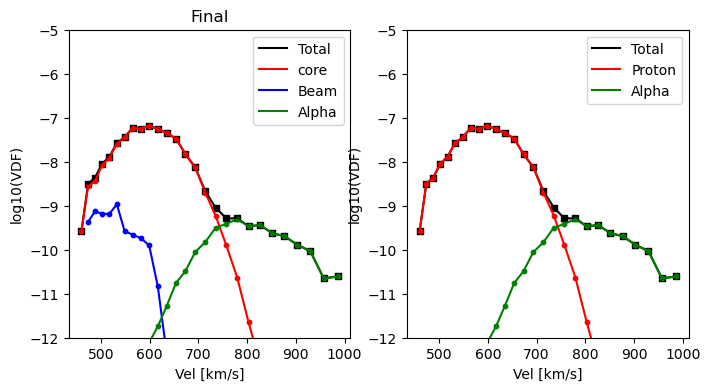

In [19]:
# Plot the final result.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_one(axes[0], axes[1], vdf_2ndcorrected, Protons_current.get_vdf(component='core'), Protons_current.get_vdf(component='beam'), Alphas_current.get_vdf() / 4, 'Final')
plt.savefig(result_path + '/GMM_final.png')

In [20]:
# ALso, let's save the moments into a text file for reference.
# Moments.
# Density.
Npcore = cal_density_Spherical(Protons_current, component='core')
Npbeam = cal_density_Spherical(Protons_current, component='beam')
Nalpha = cal_density_Spherical(Alphas_current)

# Velocity
Vpcore = cal_bulk_velocity_Spherical(Protons_current, component='core')
Vpbeam = cal_bulk_velocity_Spherical(Protons_current, component='beam')
Valpha = cal_bulk_velocity_Spherical(Alphas_current)
Vproton = cal_bulk_velocity_Spherical(Protons_current)
Vap = Valpha - Vproton

# Field Aligned velocities.
Vpcore_Baliged = rotateVectorIntoFieldAligned(Vpcore[0], Vpcore[1], Vpcore[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpcorePara, VpcorePerp = Vpcore_Baliged[0], np.sqrt(Vpcore_Baliged[1]**2 + Vpcore_Baliged[2]**2)
Vpbeam_Baliged = rotateVectorIntoFieldAligned(Vpbeam[0], Vpbeam[1], Vpbeam[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpbeamPara, VpbeamPerp = Vpbeam_Baliged[0], np.sqrt(Vpbeam_Baliged[1]**2 + Vpbeam_Baliged[2]**2)
Valpha_Baligned = rotateVectorIntoFieldAligned(Valpha[0], Valpha[1], Valpha[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
ValphaPara, ValphaPerp = Valpha_Baligned[0], np.sqrt(Valpha_Baligned[1]**2 + Valpha_Baligned[2]**2)
Vproton_Baligned = rotateVectorIntoFieldAligned(Vproton[0], Vproton[1], Vproton[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VprotonPara, VprotonPerp = Vproton_Baligned[0], np.sqrt(Vproton_Baligned[1]**2 + Vproton_Baligned[2]**2)

# Temperature
TparaProtonCore, TperpProtonCore = Temperature_para_perp(Protons_current, component='core')
TparaProtonBeam, TperpProtonBeam = Temperature_para_perp(Protons_current, component='beam')
TparaAlpha, TperpAlpha = Temperature_para_perp(Alphas_current)
TparaProton, TperpProton = Temperature_para_perp(Protons_current)

Tap_ratio = (TparaAlpha + 2 * TperpAlpha) / (TparaProton + 2 * TperpProton)

# Theta
Theta_CoreBeam = np.arctan((VpbeamPerp - VpcorePerp) / (VpbeamPara - VpcorePara)) * 180 / np.pi
Theta_CoreAlpha = np.arctan((ValphaPerp - VpcorePerp) / (ValphaPara - VpcorePara)) * 180 / np.pi

In [21]:
# Save the important parameter printed to a txt file.
moments = {
    "Which one": which_one,
    "Bsrf0": magF_SRF[0],
    "Bsrf1": magF_SRF[1],
    "Bsrf2": magF_SRF[2],
    "Vsrf0_bulk": V_bulk_SRF[0],
    "Vsrf1_bulk": V_bulk_SRF[1],
    "Vsrf2_bulk": V_bulk_SRF[2],
    "Npcore": Npcore / 1e6,
    "Npbeam": Npbeam / 1e6,
    "Nalpha": Nalpha / 1e6,
    "Np": (Npcore + Npbeam) / 1e6,
    "Nalpha_over_Np": Nalpha / (Npcore + Npbeam),
    "VpcorePara": VpcorePara / 1e3,
    "VpcorePerp": VpcorePerp / 1e3,
    "VpbeamPara": VpbeamPara / 1e3,
    "VpbeamPerp": VpbeamPerp / 1e3,
    "VprotonPara": VprotonPara / 1e3,
    "VprotonPerp": VprotonPerp / 1e3,
    "ValphaPara": ValphaPara / 1e3,
    "ValphaPerp": ValphaPerp / 1e3,
    "Vap": np.linalg.norm(Vap) / 1e3,
    "VA": VA,
    "TparaPcore": TparaProtonCore,
    "TperpPcore": TperpProtonCore,
    "TparaPbeam": TparaProtonBeam,
    "TperpPbeam": TperpProtonBeam,
    "TparaProton": TparaProton,
    "TperpProton": TperpProton,
    "TparaAlpha": TparaAlpha,
    "TperpAlpha": TperpAlpha,
    "Temperature Anisotropy": TperpProton / TparaProton,
    "Alpha Temperature Anisotropy": TperpAlpha / TparaAlpha,
    "Tap_ratio": Tap_ratio,
    "Theta_BeamCore_B": Theta_CoreBeam,
    "Theta_AlphaCore_B": Theta_CoreAlpha, }

# Save the moments, why not.
with open(result_path+'/moments.txt', 'w') as f:
    for key, value in moments.items():
        f.write(f"{key}: {value}\n")

Now you have the initial one! Go to GMM_3components.py to run for the rest of your interval!